In [7]:
%pip install tensorflow numpy matplotlib pandas seaborn scipy keras statsmodels graphviz pydot -q

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image
from time import perf_counter as perf_time
from keras.utils import to_categorical, plot_model
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow_engram.layers import Engram
from tensorflow_engram.models import EngramRegressor
from tensorflow_engram.utils import HebbianTraceMonitor, plot_hebbian_trace

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

np.random.seed(42)
tf.random.set_seed(42)

In [9]:

# Load the California housing dataset
housing = fetch_california_housing()

X = pd.DataFrame(housing.data, columns=housing.feature_names)[["AveRooms"]]
y = housing.target  # Median house value in $100,000s

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Create linear regression model for comparison
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

In [11]:
# Evaluate linear regression model
y_pred_linear = linear_model.predict(X_test_scaled)
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)
print(f"Linear Regression MSE: {linear_mse:.2f}, R^2: {linear_r2:.2f}")

Linear Regression MSE: 1.29, R^2: 0.01


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ engram_network_4                │ (None, 128)            │       214,272 │
│ (EngramNetwork)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,401 (837.50 KB)

 Trainable params: 206,209 (805.50 KB)

 Non-trainable params: 8,192 (32.00 KB)

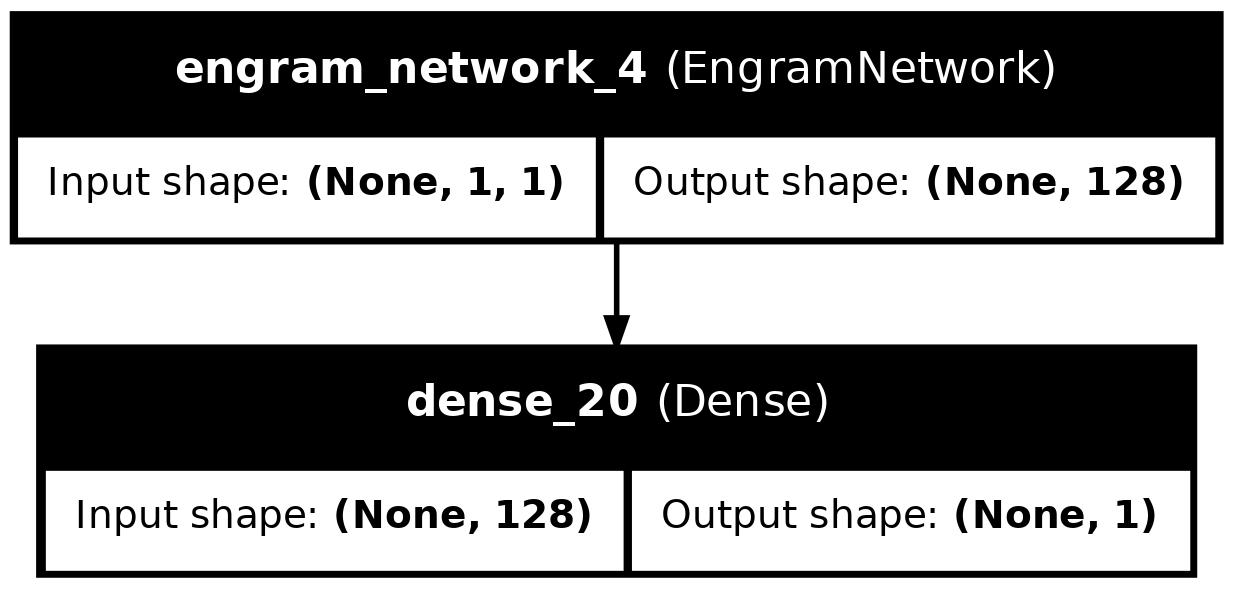

In [15]:
# Reshape the X_train_scaled for the Engram layer
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))  # Reshape to (samples, timesteps, features)
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Create the Engram model for regression
regression_model = EngramRegressor(
    input_shape=(X_train_scaled.shape[1], 1),  # (timesteps, features)
    hidden_dim=128,
    memory_size=64,
    output_dim=1,  # Single output for regression
    return_states=False,  # Changed from True to False
    return_sequences=False,
    reset_states_per_batch=True
)

trace_callback = HebbianTraceMonitor(
    X_train_scaled[:32],  # Make sure to use the reshaped data
    log_dir="examples/out/regression_hebbian_trace",
    verbose=1,
    plot_every=100,
    skip_first_plot=True
)

# Compile the model
regression_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

regression_model.summary()
plot_model(regression_model, to_file='examples/out/regression_model.png', show_shapes=True, show_layer_names=True)

In [16]:
# Train the model
history = regression_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[trace_callback],
    verbose=1
)

HebbianTraceMonitor initialized.
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.6516 - mean_squared_error: 1.6516 - val_loss: 1.2247 - val_mean_squared_error: 1.2247
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.6516 - mean_squared_error: 1.6516 - val_loss: 1.2247 - val_mean_squared_error: 1.2247
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2083 - mean_squared_error: 1.2083 - val_loss: 1.1758 - val_mean_squared_error: 1.1758
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2083 - mean_squared_error: 1.2083 - val_loss: 1.1758 - val_mean_squared_error: 1.1758
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1894 - mean_squared_error: 1.1894 - val_loss: 1.1676 - val_mean_squared_error: 1.1676
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1894 - mean_squared_error: 1.1894 - val_loss: 1.1676 - val_mean_squared_error: 1.1676
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1802 - mea

In [17]:
regression_model.evaluate(X_test_scaled, y_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0962 - mean_squared_error: 1.0962
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0962 - mean_squared_error: 1.0962


[1.100389003753662, 1.100389003753662]

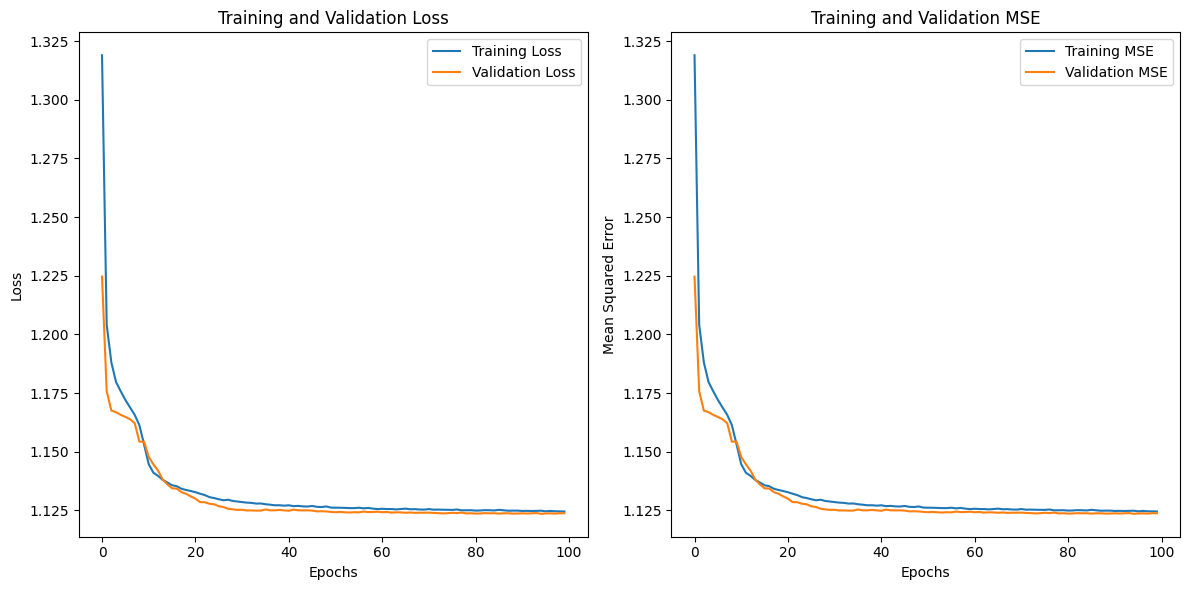

In [18]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.tight_layout()
plt.savefig('examples/out/regression_training_history.png')
plt.show()

In [20]:
# Calculate MSE and R^2 for the Engram model
y_pred_engram = regression_model.predict(X_test_scaled)
engram_mse = mean_squared_error(y_test, y_pred_engram)
engram_r2 = r2_score(y_test, y_pred_engram)
print(f"Engram Regression MSE: {engram_mse:.2f}, R^2: {engram_r2:.2f}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Engram Regression MSE: 1.10, R^2: 0.16
